# CS 7641 - HW1 Supervised Learning (Airline)

Decision Trees. For the decision tree, you should implement or steal a decision tree algorithm (and by "implement or steal" I mean "steal"). Be sure to use some form of pruning. You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

Neural Networks. For the neural network you should implement or steal your favorite kind of network and training algorithm. You may use networks of nodes with as many layers as you like and any activation function you see fit.

Boosting. Implement or steal a boosted version of your decision trees. As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.

Support Vector Machines. You should implement (for sufficiently loose definitions of implement including "download") SVMs. This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

k-Nearest Neighbors. You should "implement" (the quotes mean I don't mean it: steal the code) kNN. Use different values of k.

In [134]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score,recall_score

import time
#from sklearn import metrics


In [50]:
## Code Snippet From Sklearn Tutorial : https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Import Data

In [51]:
airline_train = pd.read_csv('Data/AirlinePassengerSatisfaction/train.csv')
airline_test = pd.read_csv('Data/AirlinePassengerSatisfaction/test.csv')
airline = pd.concat([airline_train, airline_test])

In [55]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      12988

In [56]:
airline.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [57]:
airline.groupby('satisfaction').id.count()

satisfaction
neutral or dissatisfied    73452
satisfied                  56428
Name: id, dtype: int64

In [58]:
airline.groupby('Customer Type').id.count()

Customer Type
Loyal Customer       106100
disloyal Customer     23780
Name: id, dtype: int64

In [59]:
airline.groupby('Type of Travel').id.count()

Type of Travel
Business travel    89693
Personal Travel    40187
Name: id, dtype: int64

In [60]:
airline = airline.sample(frac =.2)


# Pre-processing

In [61]:

le = LabelEncoder()
airline.satisfaction = le.fit_transform(airline.satisfaction)
airline.Gender = le.fit_transform(airline.Gender)
airline['Customer Type'] = le.fit_transform(airline['Customer Type'])
airline['Type of Travel'] = le.fit_transform(airline['Type of Travel'])

le_class = LabelEncoder()
le_class = le_class.fit(airline['Class'])
le_class.classes_ = np.array(['Eco','Eco Plus', 'Business'])
airline['Class'] = le_class.transform(airline['Class'])


In [62]:
airline.head().transpose()

,33441,751,69199,85416,32908
Unnamed: 0,33441.0,751.0,69199.0,85416.0,32908.0
id,88716.0,110397.0,50483.0,92780.0,50117.0
Gender,1.0,1.0,1.0,0.0,1.0
Customer Type,0.0,1.0,0.0,0.0,0.0
Age,58.0,27.0,37.0,85.0,56.0
Type of Travel,1.0,0.0,0.0,0.0,0.0
Class,0.0,0.0,2.0,2.0,2.0
Flight Distance,404.0,925.0,1979.0,171.0,373.0
Inflight wifi service,1.0,3.0,3.0,2.0,3.0
Departure/Arrival time convenient,5.0,3.0,3.0,2.0,3.0


# Model Run

In [63]:
airline.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [101]:
feature_cols = [ 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes']

X = airline[feature_cols]
y = airline.satisfaction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# (1)  Decision Tree


<module 'matplotlib.pyplot' from '/Users/jiheekim/miniforge3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

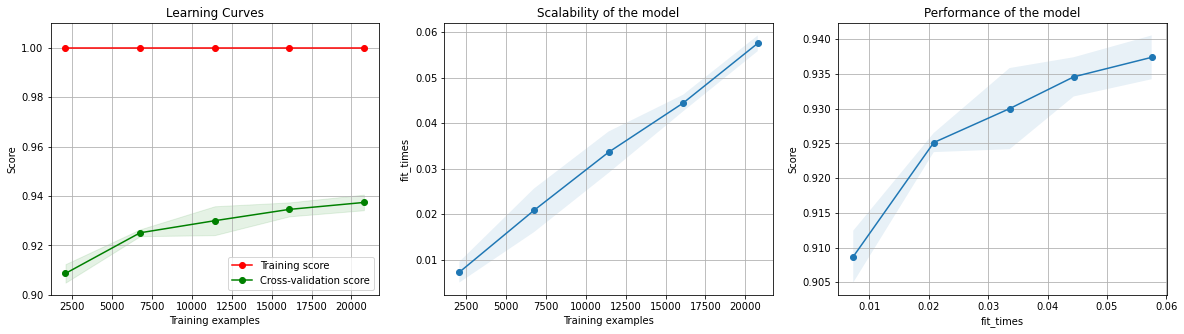

In [151]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = DecisionTreeClassifier()
plot_learning_curve( estimator,  title, x, y, axes=axes[ :], ylim=(0.9, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")


In [137]:
dtree = DecisionTreeClassifier()

start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time


start_time = time.time()
y_pred = dtree.predict(X_test)
end_time = time.time()
time_infer = end_time-start_time

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Time Train:", time_train)
print("Time Infer:", time_infer)

Accuracy: 0.943225558121632
Precision: 0.9307897071872228
Recall: 0.937863209655789
Time Train: 0.0875241756439209
Time Infer: 0.0012118816375732422


In [138]:
dtree = DecisionTreeClassifier(max_depth = 14)

start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time


start_time = time.time()
y_pred = dtree.predict(X_test)
end_time = time.time()
time_infer = end_time-start_time

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Time Train:", time_train)
print("Time Infer:", time_infer)

Accuracy: 0.9445727482678984
Precision: 0.9439635535307517
Recall: 0.9262405006705409
Time Train: 0.08467888832092285
Time Infer: 0.0011830329895019531


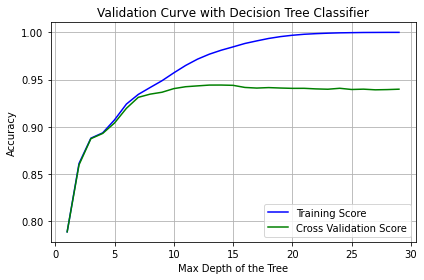

In [115]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(1, 30, 1)
train_score, test_score = validation_curve(DecisionTreeClassifier(), X, y,
                                       param_name = "max_depth",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Decision Tree Classifier")
plt.xlabel("Max Depth of the Tree")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [141]:

ml_model = DecisionTreeClassifier(max_depth = 14)
params = {
    'splitter': ['best','random'],
    'criterion': ['gini', 'entropy',],
}

clf = GridSearchCV(estimator=ml_model, param_grid=params, cv=5, n_jobs=5, verbose=1)

clf.fit(X_train, y_train)
print(clf.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'criterion': 'gini', 'splitter': 'best'}


In [143]:
dtree = DecisionTreeClassifier(max_depth = 14, criterion='gini', splitter = 'best', )

start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time


start_time = time.time()
y_pred = dtree.predict(X_test)
end_time = time.time()
time_infer = end_time-start_time

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Time Train:", time_train)
print("Time Infer:", time_infer)

Accuracy: 0.9445727482678984
Precision: 0.9439635535307517
Recall: 0.9262405006705409
Time Train: 0.0852658748626709
Time Infer: 0.0013470649719238281


In [ ]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = DecisionTreeClassifier()
plot_learning_curve( estimator,  title, x, y, axes=axes[ :], ylim=(0.9, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")


# (2)  Support Vector Machine


In [71]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.8804054921083023
Precision: 0.8763975155279503
Recall: 0.8408820023837902


In [155]:
ml_model = svm.SVC()
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

clf = GridSearchCV(estimator=ml_model, param_grid=params, cv=5, n_jobs=5, verbose=1)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


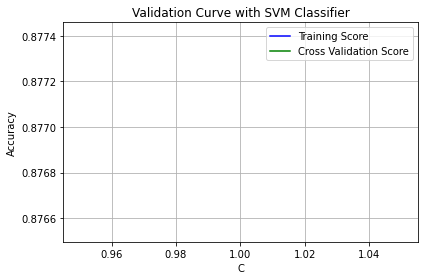

In [174]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(1, 2, 1)
train_score, test_score = validation_curve(svm.SVC(kernel = "linear"), X, y,
                                       param_name = "C",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with SVM Classifier")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [ ]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = DecisionTreeClassifier()
plot_learning_curve( estimator,  title, x, y, axes=axes[ :], ylim=(0.9, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")


# (3)  K Nearest Neighbors


In [168]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8831793687451887
Precision: 0.8895793499043977
Recall: 0.8319177469825659


In [159]:
estimator.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [160]:
ml_model = KNeighborsClassifier()
params = {
    'weights': ['uniform', 'distance'],
}

clf = GridSearchCV(estimator=ml_model, param_grid=params, cv=5, n_jobs=5, verbose=1)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'weights': 'distance'}


In [167]:
knn = KNeighborsClassifier(weights = 'distance')
knn.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8831793687451887
Precision: 0.8895793499043977
Recall: 0.8319177469825659


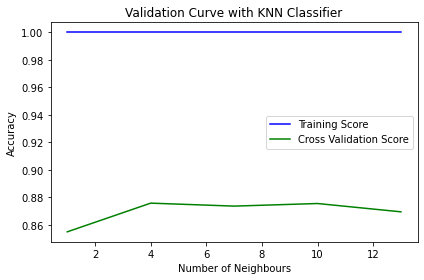

In [163]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(1, 15, 3)
train_score, test_score = validation_curve(KNeighborsClassifier(weights = 'distance'), X, y,
                                       param_name = "n_neighbors",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [164]:
np.argmax(mean_test_score)

1

In [165]:
mean_test_score[1]

0.8757700785604682

In [166]:
knn = KNeighborsClassifier(n_neighbors=4, weights = 'distance')
knn.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.8831793687451887
Precision: 0.8895793499043977
Recall: 0.8319177469825659


<module 'matplotlib.pyplot' from '/Users/jiheekim/miniforge3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

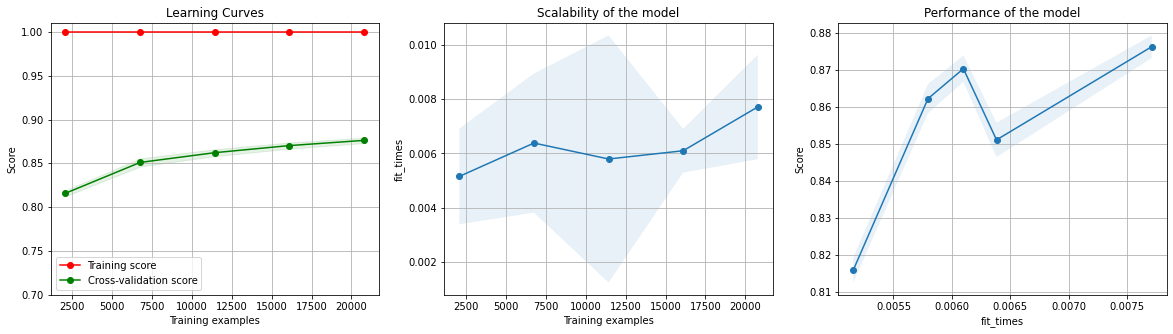

In [170]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = KNeighborsClassifier(n_neighbors=4, weights = 'distance')
plot_learning_curve( estimator,  title, x, y, axes=axes[ :], ylim=(0.7, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")


# (4)  AdaBoost


In [171]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.9309083910700539
Precision: 0.9283759124087592
Recall: 0.9097004917299956


/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 102, in fit
    raise ValueError("learning_rate must be greater than zero")
ValueError: learning_rate must be greater than zero

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_valida

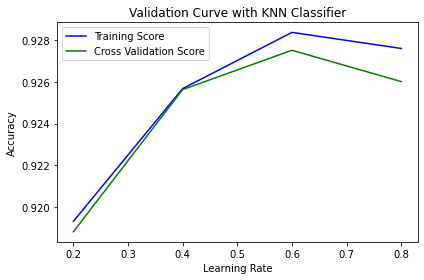

In [176]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(0, 1, 0.2)
train_score, test_score = validation_curve(AdaBoostClassifier(), X, y,
                                       param_name = "learning_rate",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [178]:
dtree = AdaBoostClassifier(learning_rate = 0.6)

start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time


start_time = time.time()
y_pred = dtree.predict(X_test)
end_time = time.time()
time_infer = end_time-start_time

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Time Train:", time_train)
print("Time Infer:", time_infer)

Accuracy: 0.9330254041570438
Precision: 0.9302961275626423
Recall: 0.9128296826106392
Time Train: 0.4318888187408447
Time Infer: 0.013016700744628906


<module 'matplotlib.pyplot' from '/Users/jiheekim/miniforge3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

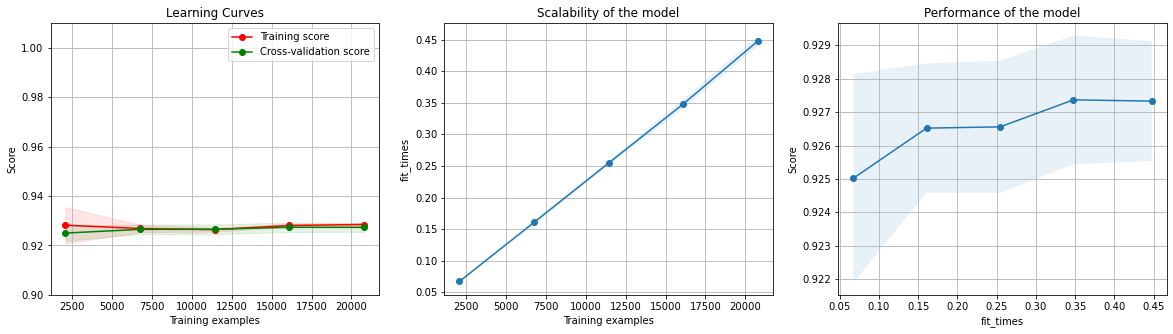

In [179]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = AdaBoostClassifier(learning_rate = 0.6)
plot_learning_curve( estimator,  title, x, y, axes=axes[ :], ylim=(0.9, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")
